In [1]:
pip install --quiet --upgrade pip torch torchvision pytorch-lightning wandb matplotlib pillow testresources

Note: you may need to restart the kernel to use updated packages.


## 4 - classify dices

In [2]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
# images = Path("RESULT_single_dices_opencv")
images = Path("RESULT_single_dices_unet")

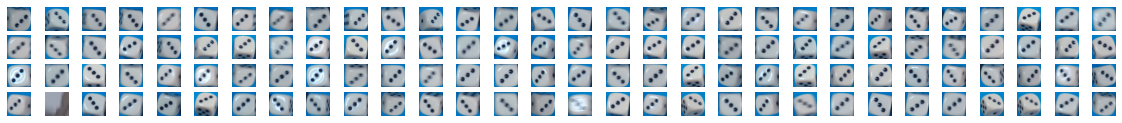

In [4]:
plt.subplots(figsize = (20, 2))
for idx, fn in enumerate(list(images.glob("3/*png"))[(4*30):(4*30)*2]):
    plt.subplot(4, 30, idx + 1)
    img = Image.open(fn)
    plt.imshow(img)
    plt.axis("off")
plt.show()

In [5]:
import torch
import torchvision
from torch.utils.data.sampler import WeightedRandomSampler
import numpy as np

In [6]:
import pytorch_lightning as lightning
lightning.seed_everything(42)

Global seed set to 42


42

In [7]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(50),
    torchvision.transforms.CenterCrop(50), # guarantee image size is not 50x51 :(
    torchvision.transforms.ToTensor()
])

In [8]:
image_train = torchvision.datasets.ImageFolder(images, transform=transforms)

In [9]:
len(image_train)

9317

In [10]:
n_val = int(len(image_train) * 0.05)  # 5% for validation
n_train = len(image_train) - n_val
train_ds, val_ds = torch.utils.data.random_split(image_train, [n_train, n_val])

train

In [11]:
train_targets = [target for _, target in train_ds]

In [12]:
image_train.classes

['1', '2', '3', '4', '5', '6']

In [13]:
counts = np.bincount(train_targets)
counts

array([2369,  814, 1668,  866, 1189, 1946])

In [14]:
weight = 1. / counts
weight

array([0.00042212, 0.0012285 , 0.00059952, 0.00115473, 0.00084104,
       0.00051387])

In [15]:
train_samples_weight = torch.tensor([weight[t] for t in train_targets])

In [16]:
train_sampler = WeightedRandomSampler(train_samples_weight, len(train_targets), replacement=True)

In [17]:
next(iter(train_sampler))

4169

In [18]:
# only to demonstrate, not used below
train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size=10, sampler=train_sampler)

In [19]:
next(iter(train_dataloader))[1]

tensor([0, 2, 5, 0, 1, 2, 4, 5, 3, 5])

validation

In [20]:
val_targets = [target for _, target in val_ds]

In [21]:
counts = np.bincount(val_targets)
counts

array([121,  37,  98,  48,  57, 104])

In [22]:
weight = 1 / counts
weight

array([0.00826446, 0.02702703, 0.01020408, 0.02083333, 0.01754386,
       0.00961538])

In [23]:
val_samples_weight = torch.tensor([weight[t] for t in val_targets])

In [24]:
val_sampler = WeightedRandomSampler(val_samples_weight, len(val_targets), replacement=True)

test data

In [25]:
# FIXME: add a testset from the 9 dices videos (need manual labels!)

In [26]:
test_ds2 = torchvision.datasets.ImageFolder("/data/dices-christian-test", transform=transforms)

In [27]:
all_test_ds = test_ds2

model

In [28]:
import wandb
wandb.login()

wandb: Currently logged in as: mfa (use `wandb login --relogin` to force relogin)


True

In [29]:
from torchmetrics import Accuracy

In [30]:
num_classes = len(image_train.classes)

In [31]:
class DiceCategoricalModel(lightning.LightningModule):
    def __init__(self, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()

        self.learning_rate = learning_rate
        self.batch_size = 16

        channels, width, height = train_ds[0][0].size()

        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=0),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Dropout(0.5),
            torch.nn.Flatten(),
            # maxpool4: 2880
            # maxpool2: 11520
            # out_channels10: 5760
            torch.nn.Linear(5760, num_classes),
        )
        self.loss = torch.nn.CrossEntropyLoss()

        acc = Accuracy()
        self.train_acc = acc.clone()
        self.valid_acc = acc.clone()

    def forward(self, x):
        return self.model(x)

    def step(self, batch, batch_idx, name):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y)
        self.log(f"{name}/loss", loss)

        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        
        if name == "train":
            self.train_acc(preds, y)
            self.log(f"{name}/acc", self.train_acc)
        else:
            self.valid_acc(preds, y)
            self.log(f"{name}/acc", self.valid_acc)

        return {"loss": loss}
    
    def training_step(self, batch, batch_nb):
        return self.step(batch, batch_nb, name="train")

    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, name="val")
    
    def test_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, name="test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(train_ds, batch_size=self.batch_size, sampler=train_sampler)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(val_ds, batch_size=self.batch_size, sampler=val_sampler)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(all_test_ds, batch_size=self.batch_size)

In [32]:
model = DiceCategoricalModel()
model

DiceCategoricalModel(
  (model): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=5760, out_features=6, bias=True)
  )
  (loss): CrossEntropyLoss()
  (train_acc): Accuracy()
  (valid_acc): Accuracy()
)

In [33]:
wandb_logger = lightning.loggers.WandbLogger(project="workshop-p3--dice-cat")
wandb_logger.watch(model, log="all")
trainer = lightning.Trainer(gpus=0, max_epochs=10, logger=wandb_logger)
trainer.fit(model)

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/mfa/.virtualenvs/machine-learning-workshop/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1823: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 34.8 K
1 | loss      | CrossEntropyLoss | 0     
2 | train_acc | Accuracy         | 0     
3 | valid_acc | Accuracy         | 0     
-----------------------------------------------
34.8 K    Trainable params
0         Non-trainable params
34.8 K    Total params
0.139     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/mfa/.virtualenvs/machine-learning-workshop/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:486: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/home/mfa/.virtualenvs/machine-learning-workshop/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/mfa/.virtualenvs/machine-learning-workshop/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [34]:
trainer.test(ckpt_path='best')

Restoring states from the checkpoint path at /home/mfa/machine-learning-workshop/part3/workshop-p3--dice-cat/1zxmbadw/checkpoints/epoch=9-step=5540.ckpt
Loaded model weights from checkpoint at /home/mfa/machine-learning-workshop/part3/workshop-p3--dice-cat/1zxmbadw/checkpoints/epoch=9-step=5540.ckpt
/home/mfa/.virtualenvs/machine-learning-workshop/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/acc            0.20000000298023224
        test/loss           10.033441543579102
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/loss': 10.033441543579102, 'test/acc': 0.20000000298023224}]

In [35]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
test/acc,▁
test/loss,▁
train/acc,▁████████████████▇██▇██████████▇███▆████
train/loss,█▂▂▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val/acc,▁▂▂▆███▇██
val/loss,█▇▄▂▁▁▁▁▁▂
epoch,9
test/acc,0.2
test/loss,10.03344


In [36]:
img = val_ds[0][0][None, :]
r = model(img)
r

tensor([[ -7.0652,   4.1466,  -6.9816,  -1.2141,  -3.0163, -10.8709]],
       grad_fn=<AddmmBackward0>)

In [37]:
image_train.classes

['1', '2', '3', '4', '5', '6']

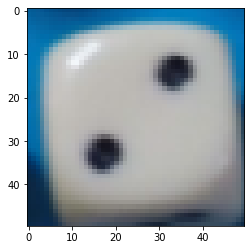

In [38]:
plt.imshow(img[0].permute(1,2,0).data)
plt.show()

In [39]:
img = all_test_ds[0][0][None, :]
r = model(img)
r

tensor([[  9.6328,   0.8941,   2.0104, -22.2615, -10.3379,   3.7761]],
       grad_fn=<AddmmBackward0>)

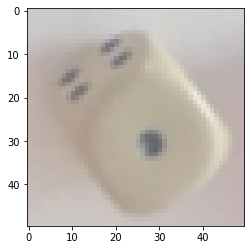

In [40]:
plt.imshow(img[0].permute(1,2,0).data)
plt.show()